# Visión Estéreo. 

### Luis ROSARIO TREMOULET

Visión Tridimensional 2021-22 .
Abril 2022.

## Objetivos


Los objetivos de esta práctica son:
* reconstruir puntos de una escena a partir de una serie de correspondencias manuales entre dos imágenes calibradas;
* determinar la geometría epipolar de un par de cámaras a partir de sus matrices de proyección;
* hacer una reconstrucción densa de la escena.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica`` del tema de visión estéreo. Esta carpeta contiene:
* Una serie de pares estéreo en el directorio images;
el sufijo del fichero indica si corresponde a la cámara
izquierda (_left) o a la derecha (_right). Bajo el
directorio ``rectif`` se encuentran varios pares estéreo
rectificados.
* Un conjunto de funciones auxiliares de ``Python`` en 
el módulo ``misc.py``. La descripción de las funciones
puede consultarse con el comando help o leyendo
su código fuente.
* El archivo ``cameras.npz`` con las matrices de proyección del par de cámaras con el que se tomaron todas las imágenes con prefijo minoru.

## 1. Introducción

En los problemas de visión estéreo se supondrá la existencia de un par de cámaras calibradas cuyas matrices de proyección $\mathbf{P}_i$ vienen dadas
por $$\mathbf{P}_1 = \mathbf{K}_1\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_1 & \mathbf{t}_1\\ \mathbf{0}^T & 1
    \end{bmatrix},$$ $$\mathbf{P}_2 = \mathbf{K}_2\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_2 & \mathbf{t}_2\\ \mathbf{0}^T & 1
    \end{bmatrix}.$$
    
En esta práctica se usarán las matrices de proyección de
dos cámaras para determinar la posición tridimensional
de puntos de una escena. Esto es posible siempre que se
conozcan las proyecciones de cada punto en ambas cámaras. Desafortunadamente, esta información no suele estar
disponible y para obtenerla es preciso emplear el contenido
de las imágenes (sus píxeles) en un proceso de búsqueda
conocido como puesta en correspondencia. Conocer las matrices de proyección de las cámaras permite acotar el área
de búsqueda gracias a las restricciones que proporciona la
geometría epipolar.

In [1]:
# uncomment to show results in a window
#%matplotlib tk
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy.linalg as npla
import misc

## 1. Reconstrucción

Teniendo un conjunto de correspondencias entre dos
imágenes, con matrices de calibración $P_i$ conocidas, es
posible llevar a cabo una reconstrucción tridimensional de
dichos puntos. En el fichero ``cameras.npz`` se encuentran
las matrices de proyección para las dos cámaras. Para cargar
este fichero:

In [2]:
cameras = np.load("cameras.npz")
P1 = cameras["left"]
P2 = cameras["right"]

print("P1=\n", P1)
print("P2=\n", P2)

P1=
 [[-1.59319023e+02  4.10068927e+02 -8.61429776e+01  5.96021124e+04]
 [ 9.56736123e+01 -6.85256589e+00 -4.31511155e+02  2.98592912e+04]
 [-8.69896273e-01 -7.51069223e-02 -4.87482742e-01  5.44164509e+02]]
P2=
 [[-1.49296958e+02  4.20482251e+02 -8.03699899e+01  2.66669558e+04]
 [ 9.61686671e+01 -2.92284678e+00 -4.41950717e+02  3.12991880e+04]
 [-8.64354364e-01 -5.83462724e-02 -4.99486983e-01  5.42414607e+02]]


Todas las imágenes con el prefijo minoru comparten este par de matrices de proyección.

Leemos las imágenes y marcamos al menos seis puntos correspondientes en cada una de ella.

In [3]:
import glob
for img in glob.glob("images/*"): print(img)

images/minoru_eraser2_left.jpg
images/minoru_can_left.jpg
images/minoru_cube_left.jpg
images/minoru_cube3_right.jpg
images/minoru_can_right.jpg
images/minoru_cube3_left.jpg
images/minoru_cube_right.jpg
images/minoru_eraser2_right.jpg


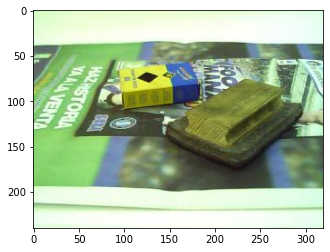

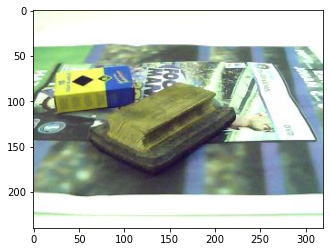

In [4]:
%matplotlib inline
img1 = cv2.imread("images/minoru_eraser2_left.jpg")
img2 = cv2.imread("images/minoru_eraser2_right.jpg")

plt.figure()
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.figure()
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

In [35]:
# [LUIS] He descomentado porque no se puede hacer directamente en el jupyter
#
# I am saving the points threw pickle
import pickle

select_points = False

if select_points:
    %matplotlib tk
    pt1, pt2 = misc.askpoints(img1, img2)
    
    output = open('pt1.pkl', 'wb')
    output2 = open('pt2.pkl', 'wb')

    pickle.dump(pt1, output)
    pickle.dump(pt2, output2)

    output.close()
    output2.close()
else:
    pt1_file = open('pt1.pkl', 'rb')
    pt2_file = open('pt2.pkl', 'rb')

    pt1 = pickle.load(pt1_file)
    pt2 = pickle.load(pt2_file)

    pt1_file.close()
    pt2_file.close()

print(f'point 1 : {pt1}')
print(f'point 2 : {pt2}')

# Recomendación: Una vez marcados la primera vez con toda la precisión 
# posible, generar dos arrays de numpy aquí, pt1 y pt2, con las
# coordenadas marcadas (para no tener que volver a marcarlas). 
# Una vez colocadas esas variables ¡comentar el código que llama a 
# miscaskpoints!

point 1 : [[216.18817204 215.71505376 168.40322581 168.87634409 149.00537634
   82.7688172  100.74731183  98.38172043  95.06989247 172.18817204
  181.65053763 182.12365591 221.8655914  290.46774194 303.24193548]
 [129.41537634 151.65193548 131.30784946 113.32935484 128.46913978
  116.16806452 109.07129032  90.61967742  65.5444086   58.44763441
   81.63043011  99.13580645  61.75946237  53.71645161 126.57666667]
 [  1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.        ]]
point 2 : [[124.10215054 125.52150538  81.99462366  81.52150538  64.48924731
    7.24193548  26.16666667  23.80107527  25.22043011 106.12365591
  110.85483871 111.32795699 161.00537634 234.33870968 228.66129032]
 [135.56591398 155.91       136.51215054 117.58741935 132.7272043
  120.42612903 111.91        94.87774194  68.85623656  62.23258065
   85.88849462 105.75946237  65.5444086   57.50139785 

In [36]:
def show_lines(im1, im2, p1, p2, mode):
    plt.figure(figsize=(20, 20))
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2)

    if mode=="line":
        ax1.plot(p1[0,:], p1[1,:], '-r', markersize=20)
        ax2.plot(p2[0,:], p2[1,:], '-r', markersize=20)
    else:
        ax1.plot(p1[0,:], p1[1,:], '.r', markersize=20)
        ax2.plot(p2[0,:], p2[1,:], '.r', markersize=20)

    ax1.imshow(cv2.cvtColor(im1, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(im2, cv2.COLOR_BGR2RGB))

    plt.show()

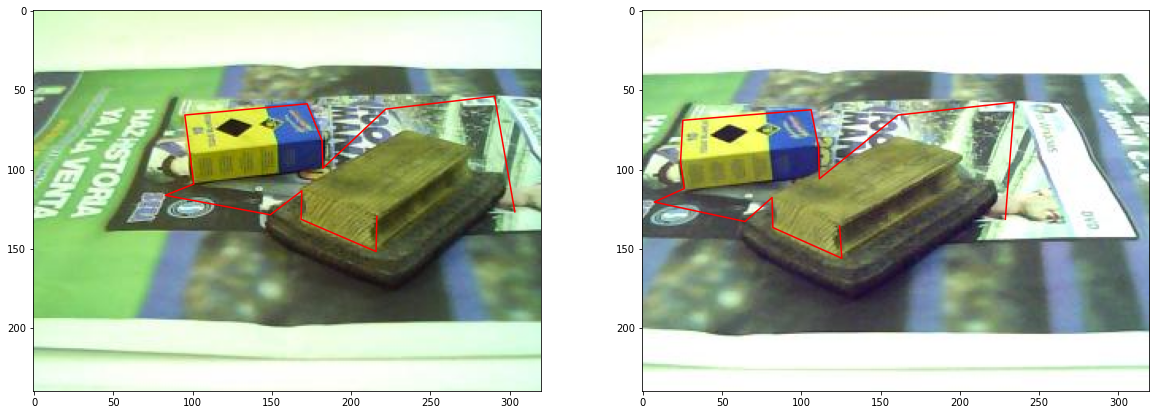

In [37]:
%matplotlib inline
show_lines(img1, img2, pt1, pt2, "line")

**Ejercicio 1.** Implementa la función ``M = reconstruct(points1, points2, P1, P2)``
que, dados una serie de N puntos 2D ``points1`` de la primera imagen y sus 
N homólogos ``points2`` de la segunda imagen
(ambos en coordenadas homogéneas, 3 x N), y el par de matrices
de proyección P1 y P2 de la primera y la segunda cámara
respectivamente, calcule la reconstrucción tridimensional
de cada punto. De ese modo, si ``points1`` y
``points2`` son 3 × N , la matriz resultante M debe ser 4 × N.

El tipo de reconstrucción debe ser algebraico, no geométrico.


In [10]:
# [LUIS] Devuelve solamente los puntos 2d, que queremos calcular
def get_n_point(points1, points2, n):
    return points1[:,n], points2[:,n]

# [LUIS] Coord homogeneas en cartesianas
def homog_to_cartes_2D(point):
    return np.true_divide(point[0:2], point[2])

def homog_to_cartes_3D(point):
    return np.true_divide(point[0:3], point[3])

def reconstruct(points1, points2, P1, P2):
    crts1 = []
    crts2 = []
    homog_matrix = []
    for i, _ in enumerate(points1[0]):
        a, b = get_n_point(points1, points2, i)
        crts1.append(homog_to_cartes_2D(a))
        crts2.append(homog_to_cartes_2D(b))
        
    for i, _ in enumerate(crts1):
        l = crts1[i][0]
        m = crts1[i][1]
        n = crts2[i][0]
        o = crts2[i][1]

        S = np.array([P1[0,].T - l * P1[2,].T, 
                  P1[1,].T - m * P1[2,].T,
                  P2[0,].T - n * P2[2,].T, 
                  P2[1,].T - o * P2[2,].T])
        crts_matrix = npla.pinv(S[:, :3]) @ -S[:, -1]
        
        # añadir 1 : cart -> homog
        homog_matrix.append(np.append(crts_matrix, 1))
        
        
    homog_matrix = np.array(homog_matrix)
    
    return homog_matrix.T

In [11]:
# [LUIS] Solo para hacer tests
a, b = get_n_point(pt1, pt2, 2)
print(a)
print(b)
c = homog_to_cartes_2D(a)
print(c)

[168.40322581 131.30784946   1.        ]
[ 81.99462366 136.51215054   1.        ]
[168.40322581 131.30784946]


Reconstruye los puntos marcados y pinta su estructura 3D.

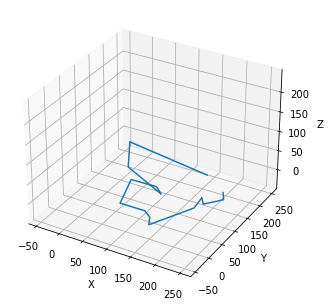

In [12]:
%matplotlib inline

# reconstruct
mM = reconstruct(pt1, pt2, P1, P2)

# convert from homog to cartesian
mM /= mM[3, :]
mM /= mM[3, :]

# plot 3D
misc.plot3D(mM[0,:],mM[1,:],mM[2,:])

**Ejercicio 2.**  Elige un par estéreo de las imágenes del conjunto "building" de la práctica de calibración y realiza una reconstrucción de un conjunto de puntos de dicho edificio estableciendo las correspondencias a mano.

En este caso tenemos la cámara calibrada dado que las imágenes las hemos capturado con la misma cámara que en la práctrica de calibración. Nos faltarían la posición relativa entre una cámara y la otra. Utilizar algunas funciones de OpenCV en el módulo de calibración de calib3d puede ser de gran ayuda.

In [13]:
# From the calibration in homework 1.
K_building = np.array(
    [[3.19998949e+03, 0.00000000e+00, 1.97733219e+03],
    [0.00000000e+00, 3.19998949e+03, 1.45301331e+03],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
# Do not use radial distorsion parameters!!

img1_building = cv2.imread('building/build_001.jpg')
img2_building = cv2.imread('building/build_002.jpg')

# Get points in both images
select_points = False

if select_points:
    %matplotlib tk
    pt1_building, pt2_building = misc.askpoints(img1_building,img2_building)
    
    output = open('pt1_building.pkl', 'wb')
    output2 = open('pt2_building.pkl', 'wb')

    pickle.dump(pt1_building, output)
    pickle.dump(pt2_building, output2)

    output.close()
    output2.close()
else:
    pt1_file = open('pt1_building.pkl', 'rb')
    pt2_file = open('pt2_building.pkl', 'rb')

    pt1_building = pickle.load(pt1_file)
    pt2_building = pickle.load(pt2_file)

    pt1_file.close()
    pt2_file.close()

print(f'point 1 : {pt1_building}')
print(f'point 2 : {pt2_building}')

point 1 : [[1.14350000e+03 1.98243333e+03 2.99150000e+03 3.15576667e+03
  2.00003333e+03 1.02616667e+03 8.20833333e+02 1.98830000e+03
  3.47256667e+03 3.50776667e+03]
 [8.80798667e+02 1.35732000e+02 7.92798667e+02 2.02479867e+03
  1.78426533e+03 2.08933200e+03 2.54106533e+03 2.44719867e+03
  2.50586533e+03 2.71119867e+03]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]
point 2 : [[9.46166667e+02 1.79683333e+03 2.79416667e+03 2.95843333e+03
  1.82616667e+03 8.28833333e+02 6.17633333e+02 1.80856667e+03
  3.25763333e+03 3.28696667e+03]
 [8.51465333e+02 1.18132000e+02 7.86932000e+02 2.00133200e+03
  1.77839867e+03 2.07173200e+03 2.54693200e+03 2.42959867e+03
  2.47066533e+03 2.66426533e+03]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  1.00000000e+00 1.00000000e+00]]


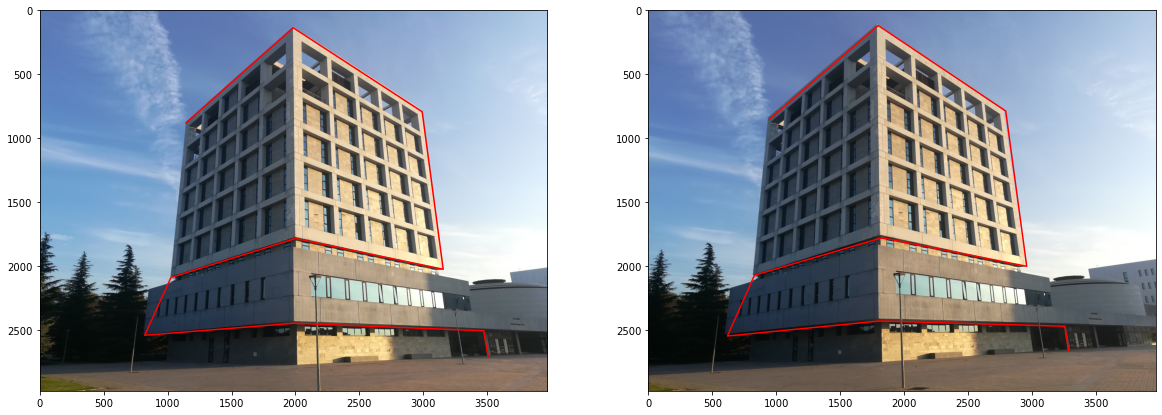

In [14]:
%matplotlib inline

show_lines(img1_building, img2_building, pt1_building, pt2_building, "line")

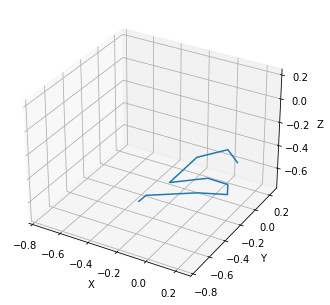

In [15]:
# Find P1_building and P2_building 
# (projection matrices of the two selected images)
P1_building = None
P2_building = None # To find

kpn_cur = pt1_building[:2, :].T
kpn_ref = pt2_building[:2, :].T

E, _ = cv2.findEssentialMat(kpn_cur, kpn_ref, K_building)
_, R, t, mask = cv2.recoverPose(E, kpn_cur, kpn_ref, K_building)
P = np.vstack([np.hstack([R, t]), [0, 0, 0, 1]])

P1_building = K_building @ np.eye(3, 4)
P2_building = P1_building @ P

# reconstruct
mM_building = reconstruct(pt1_building, pt2_building, P1_building , P2_building )

# convert from homog to cartesian
mM_building /= mM_building[3, :]

# plot 3D
misc.plot3D(mM_building[0,:],mM_building[1,:],mM_building[2,:])

In [16]:
# El resto de la práctica lo podemos hacer con los datos de las 
# dos imágenes de prefijo minoru o las dos seleccionadas del directorio 
# building 

usar_par_estereo_building = False

if usar_par_estereo_building:
    P1 = P1_building
    P2 = P2_building
    img1 = img1_building
    img2 = img2_building
    pt1 = pt1_building
    pt2 = pt2_building
    K = K_building
    mM = mM_building

**Ejercicio 3.**  Reproyecta los resultados de la reconstrucción
en las dos cámaras y dibuja las proyecciones sobre las
imágenes originales. Pinta también en otro color los puntos seleccionados manualmente. Comprueba si las proyecciones coinciden con los puntos marcados a mano. Comenta los resultados.
Para dibujar los puntos puedes usar la función plothom
de la práctica anterior o la versión que se distribuye con esta
práctica (misc.plothom).

In [17]:
print(P1.shape)
print(mM.shape)
print(mM)

(3, 4)
(4, 15)
[[235.70204598 236.59160307 214.75556    211.49998599 205.20845438
  151.68705497 143.71291811 135.09692224  89.80396557  63.73073244
  111.42951395 121.00346727  21.75798595 -31.0371642  155.56285506]
 [119.19948986 119.59459517  82.40166307  82.82791574  65.701407
   -4.2074987   12.79689663  10.27989727  -0.49346629  82.13829388
   92.91178403  93.57760451 141.63445921 236.06134902 208.42515359]
 [ 23.5729869    5.31308154   9.97087098  25.14024261   7.52365215
   -9.49533712  -4.86773462  10.29966967  19.61963631  17.6270041
    9.91257386  -6.59453509  -1.98739523 -10.71375591 -17.11690296]
 [  1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.
    1.           1.           1.           1.           1.        ]]


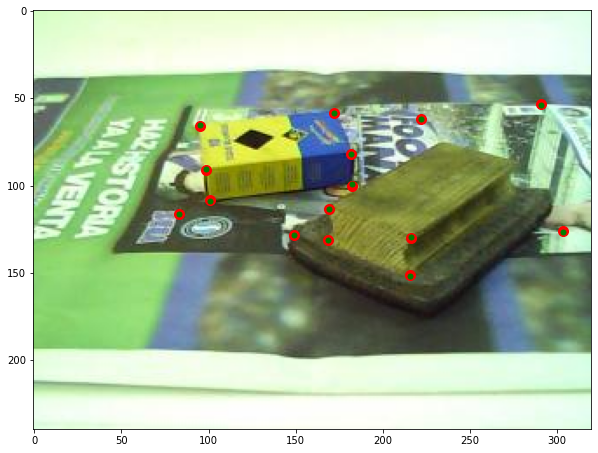

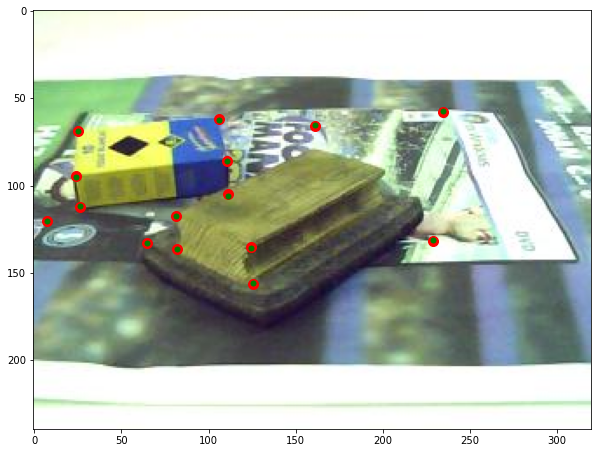

In [18]:
%matplotlib inline

# Project points in both cameras
proy1 = P1 @ mM
proy2 = P2 @ mM

# Plot with misc.plothom()
# show_lines(img1, img2, proy1, proy2, "point")

plt.figure(figsize=(10, 10))
misc.plothom(proy1,'r.', markersize=20)
misc.plothom(pt1,'g.', markersize=10)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(10, 10))
misc.plothom(proy2,'r.', markersize=20)
misc.plothom(pt2,'g.', markersize=10)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

## 2. Geometría epipolar

La geometría epipolar deriva de las relaciones que aparecen en las proyecciones de una escena sobre un par de
cámaras. La matriz fundamental $\mathbf{F}$, que depende exclusivamente de la configuración de las cámaras y no de la escena
que éstas observan, es la representación algebráica de dicha
geometría: a partir de ella se pueden calcular los epipolos
y las líneas epipolares. La relación entre un par de cámaras
$\mathbf{P}_1$, $\mathbf{P}_2$ y la matriz fundamental es de n -a- 1 (salvo factor de
escala). Es decir, dadas dos cámaras calibradas, sólo tienen
una matriz fundamental (excepto un factor de escala); dada
una matriz fundamental existen infinitas configuraciones de
cámaras posibles asociadas a ella.

### 2.1 Estimación de la matriz fundamental

**Ejercicio 4.** Implementa la función ``F = projmat2f(P1, P2)``
que, dadas dos matrices de proyección, calcule la matriz
fundamental asociada a las mismas. $\mathbf{F}$ debe ser tal que,
si $m_1$ de la imagen 1 y $m_2$ de la imagen 2 están en
correspondencia, entonces $m_2^\top F m_1 = 0$.

In [19]:
def projmat2f(P1, P2):
    """ Calcula la matriz fundamental a partir de dos matrices de proyeccion"""

    K_1, R_1, C_1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
    C_1 = homog_to_cartes_3D(C_1)
    t_1 = -R_1 @ C_1
    
    K_2, R_2, C_2, _, _, _, _ = cv2.decomposeProjectionMatrix(P2)
    C_2 = homog_to_cartes_3D(C_2)
    t_2 = -R_2 @ C_2
#     tmp_C_1 = R_1.T @ t_1
#     tmp_C_2 = R_2.T @ t_2 (same as neg)
    tmp_C_1 = np.negative(C_1)
    tmp_C_2 = np.negative(C_2)
    v = tmp_C_2 - tmp_C_1
    
    # Compute the skew-symmetric matrix of a vector
    skew_result = misc.skew(v)
    F = npla.pinv(K_2).T @ R_2 @ skew_result @ R_1.T @ npla.pinv(K_1)

    if F[2,2] != 0:
        return F / F[2,2]
    else:
        return F

In [20]:
# [LUIS] Solo para hacer tests
K_1, R_1, C_1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
C_1 = homog_to_cartes_3D(C_1)
t_1 = -R_1 @ C_1
    
K_2, R_2, C_2, _, _, _, _ = cv2.decomposeProjectionMatrix(P2)
C_2 = homog_to_cartes_3D(C_2)
t_2 = -R_2 @ C_2
test_C_1 = R_1.T @ t_1
test_C_2 = R_2.T @ t_2
test_C_3 = np.negative(C_1)
test_C_4 = np.negative(C_2)

print(np.isclose(test_C_1, test_C_3))
print(np.isclose(test_C_2, test_C_4))

[[ True]
 [ True]
 [ True]]
[[ True]
 [ True]
 [ True]]


In [21]:
# compute Fundamental matrix
F = projmat2f(P1, P2)
print("F =\n", F)

F =
 [[ 1.10036380e-06 -3.47150783e-04  1.13107937e-01]
 [ 1.07305234e-03  5.73532923e-04  1.80751930e+01]
 [-2.98810608e-01 -1.86707950e+01  1.00000000e+00]]


**Ejercicio 5** ¿Cómo es la matriz fundamental de dos cámaras
que comparten el mismo centro? (Por ejemplo, dos cámaras
que se diferencian sólo por una rotación.)

##### Sabiendo que la matriz fundamental depende exclusivamente de la configuración de las cámaras y no de la escena :
##### La F de dos cámaras que comparten el mismo centro sera una matriz 3x3 donde todos los valores tendra el valor 0 menos el sesgo que sera igual a 1

### 2.2 Comprobación de F

En los siguientes dos ejercicios vamos a comprobar que la matriz F estimada a partir de P1 y P2 es correcta.

**Ejercicio 6.** Comprueba que F es la matriz fundamental asociada a las cámaras ``P1`` y ``P2``. Para ello puedes utilizar el resultado 9.12, que aparece en la página 255 del libro Hartley, Zisserman. "Multipe View Geometry in Computer Vision." (sedond edition). Cambridge University Press, 2003:

"A non zero marix $F$ is a fundamental matrix corresponding to a pair of camera matrices $P$ and $P′$ if and only if $P'^TFP$ is skew symmetric" 

In [22]:
K_1, R_1, C_1, _, _, _, _ = cv2.decomposeProjectionMatrix(P1)
C_1 = homog_to_cartes_3D(C_1)
t_1 = -R_1 @ C_1
    
K_2, R_2, C_2, _, _, _, _ = cv2.decomposeProjectionMatrix(P2)
C_2 = homog_to_cartes_3D(C_2)
t_2 = -R_2 @ C_2

In [23]:
check_P1 = K_1 @ np.hstack([R_1, t_2])
check_P2 = K_2 @ np.hstack([R_2, t_2]) # Same t_2

# compute Fundamental matrix
F = projmat2f(check_P1, check_P2)
print("F =\n", np.round(F))

F =
 [[ 0. -0.  0.]
 [ 0. -0. -0.]
 [-0.  0.  1.]]


### Check 
"A non zero marix $F$ is a fundamental matrix corresponding to a pair of camera matrices $P$ and $P′$ if and only if $P'^TFP$ is skew symmetric" 

In [24]:
is_zero = not np.any(F)
print(f'Non zero : {is_zero}')

# A.T = -A
if not is_zero:
    check_if_skew = check_P2.T @ (F @ check_P1)
    print(f'Is skew symmetric ? : {np.allclose(np.round(check_if_skew.T), np.round(-check_if_skew))}')

Non zero : False
Is skew symmetric ? : True


También se puede comprobar geométricamente la bondad de una matriz F, si  las epipolares con ella estimadas pasan por el homólogo de un punto dado en una de las imágenes.

Dada la matriz fundamental $\mathbf{F}$ entre las cámaras 1 y 2,
se puede determinar, para un determinado punto $m_1$ en la
imagen de la cámara 1, cuál es la recta epipolar $l_2$ donde se
encontrará su homólogo en la cámara 2: $$l_2 = \mathbf{F} m_1.$$

Las siguientes dos funciones sirven para comprobar esta
propiedad. En primer lugar, se necesita una función que
dibuje rectas expresadas en coordenadas homogéneas, es
decir, la versión de plothom para rectas en lugar de puntos.

**Ejercicio 7.** Implementa la función ``plothline(line)``
que, dada una línea expresada en coordenadas homogéneas,
la dibuje.

In [25]:
def plothline(line, axes = None):
    """Plot a line given its homogeneous coordinates.
    
    Parameters
    ----------
    line : array_like
        Homogeneous coordinates of the line.
    axes : AxesSubplot
        Axes where the line should be plotted. If not given,
        line will be plotted in the active axis.
    """    
    if axes == None:
        axes = plt.gca()
    
    [x0, x1, y0, y1] = axes.axis()
    
    #     (x0, y0) ._____________________. (x1, y0)
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #     (x0, y1) .---------------------. (x1, y1)
 
    l1, l2, l3 = line
    y0_2 = -(l3 + l1 * x0)
    y1_2 = -(l3 + l1 * x1)

    plotline = axes.plot([x0, x1], [y0_2 / l2, y1_2 / l2], 'r-')
    axes.axis([x0, x1, y0, y1])
    return plotline

**Ejercicio 8.** Completa la función ``plot_epipolar_lines(image1, image2, F)``
que, dadas dos imágenes y la matriz fundamental que
las relaciona, pide al usuario puntos en la imagen 1 y
dibuje sus correspondientes epipolares en la imagen 2 usando ``plothline``.

In [26]:
def plot_epipolar_lines(image1, image2, F):
    """Ask for points in one image and draw the epipolar lines for those points.
    
    Parameters
    ----------
    image1 : array_like
        First image.
    image2 : array_like
        Second image.
    F : array_like
        3x3 fundamental matrix from image1 to image2.
    """
    # Prepare the two images.
    fig = plt.gcf()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image1)
    ax1.axis('image')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(image2)
    ax2.axis('image')
    plt.draw()
    
    ax1.set_xlabel("Choose points in left image (or right click to end)")
    point = plt.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    while len(point) != 0:
        # point has the coordinates of the selected point in the first image.
        point = np.hstack([np.array(point[0]), 1])
        ax1.plot(point[0], point[1], '.r')
        
        # POR HACER: Determine the epipolar line.
        line = F @ point
        
        # Plot the epipolar line with plothline (the parameter 'axes' should be ax2).
        plothline(line, axes=ax2)
        
        plt.draw()
        # Ask for a new point.
        point = plt.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    
    ax1.set_xlabel('')
    plt.draw()

Utiliza esta función con un par de imágenes llamándola
de dos formas diferentes: seleccionando puntos en la imagen
izquierda y dibujando las epipolares en la imagen derecha
y viceversa. Comprueba en ambos casos que las epipolares
siempre pasan por el punto de la segunda imagen correspondiente al seleccionado en la primera. Esto confirmara la corrección de la matriz F.

Añade dos figuras una que muestre la selección de puntos en
la imagen izquierda y las rectas correspondientes en la
imagen derecha, y otra que lo haga al revés. Indica para
ambos casos qué matriz fundamental has usado al llamar a
``plot_epipolar_lines``.

In [27]:
%matplotlib tk
# Matriz fundamental = F
plot_epipolar_lines(img1, img2, F)

# VER Imagen n°1

In [28]:
# Matriz fundamental = F.T
plot_epipolar_lines(img2, img1, F.T)

# VER Imagen n°2

##  3. Rectificación de imágenes

La mayoría de algoritmos de puesta en correspondencia,
incluyendo el que se va a implementar en esta práctica,
requieren que las imágenes de entrada estén rectificadas.

Dos imágenes están rectificadas si sus correspondientes epipolares están alineadas horizontalmente. La rectificación de
imágenes facilita enormemente los algoritmos de puesta en
correspondencia, que pasan de ser problemas de búsqueda
bidimensional a problemas de búsqueda unidimensional
sobre filas de píxeles de las imágenes. En el material de
la práctica se han incluido dos funciones que rectifican
(mediante un método lineal) dos imágenes. La función
``H1, H2 = misc.projmat2rectify(P1, P2, imsize)``
devuelve, dadas las dos matrices de proyección y el tamaño de las imágenes en formato (filas,columnas), las
homografías que rectifican, respectivamente, la imagen 1
y la imagen 2. La función ``projmat2rectify`` hace uso
de ``projmat2f``, por lo que
es necesario que esta función esté disponible.

**Ejercicio 9.** Se tienen dos imágenes no rectificadas ``im1`` e
``im2``, y su matriz fundamental asociada $\mathbf{F}$ . Con el procedimiento explicado, se encuentran un par de homografías $\mathbf{H}_1$ y $\mathbf{H}_2$ que dan lugar a las imágenes rectificadas ``O1`` y ``O2``. ¿Cuál es la matriz fundamental $\mathbf{F}′$ asociada a estas dos imágenes? ¿Por qué?

Nota: F ′ depende exclusivamente de F , H1 y H2.

**Ejercicio 10.** Rectifica el par de imágenes estéreo ``img1`` e ``img2`` implementando el algoritmo de ``Fusiello, Trucco y Verri`` visto en clase.

Para este ejercicio puede ser útil la función ``cv2.decomposeProjectionMatrix``.

In [29]:
def projmat2rectify_fusiello(P1, P2):
    """
    Determine the transformation for the epipolar rectification.
    
    Given the projection matrices of an stereo pair and the size
    of the images from the cameras, this function returns a pair
    of linear transformations (i.e., homographies) which rectify
    the images so that the epipolar lines correspond to the scanlines.
    
    "A Compact Algorithm for Rectification of Stereo Pairs"
    Andrea Fusiello, Emanuele Trucco, Alessandro Verri.
    IJCV 2000
    
    Parameters
    ----------
    P1, P2 : ndarray
        Projection matrices of the cameras.
    imsize : tuple
        The size of the image (height, width)
    """
#     cameraMatrix, rmat, tvect, rmatX, rmatY, rmatZ, eulerAngles = cv2.decomposeProjectionMatrix(projMatrix)
#     rvec,_ = cv2.Rodrigues(rotMatrix)

# We already have K_1, R_1, t_1, K_2, R_2, t_2
    
    K = (K_1 + K_2) / 2
    
    r_1 = (C_2 - C_1).squeeze()
    norm_r_1 = np.linalg.norm(r_1)
    
    r_2 = np.cross(R_2[2], r_1)
    norm_r_2 = np.linalg.norm(r_2)
    
    r_3 = np.cross(r_1, r_2)
    norm_r_3 = np.linalg.norm(r_3)
    r_vect = np.array([r_1 / norm_r_1, r_2 / norm_r_2, r_3 / norm_r_3])
    
    K[0,1] = 0 # cart to homog
    H1 = K @ r_vect @ R_1.T
    H2 = K @ r_vect @ R_2.T
    
    H1 = H1 @ npla.inv(K_1)
    H2 = H2 @ npla.inv(K_2)
    
    return H1, H2, K, r_vect

In [30]:
H1, H2, K, r_vect = projmat2rectify_fusiello(P1, P2)
print("H1=\n", H1)
print("H2=\n", H2)
O1 = cv2.warpPerspective(img1, H1, (img1.shape[1], img1.shape[0]))
O2 = cv2.warpPerspective(img2, H2, (img2.shape[1], img2.shape[0]))

H1=
 [[ 1.01676012e+00 -3.86138637e-03 -1.51407995e+01]
 [ 1.59354261e-02  1.01298745e+00 -4.75367394e+00]
 [ 5.85838406e-05  3.12432335e-05  9.86843184e-01]]
H2=
 [[ 9.94383316e-01 -3.61872783e-03  4.41166520e-01]
 [ 6.11218289e-03  9.91177544e-01 -4.74904997e+00]
 [ 1.87336766e-05 -6.81749941e-08  9.97267063e-01]]


Text(0.5, 1.0, 'O2')

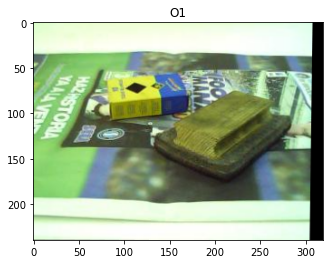

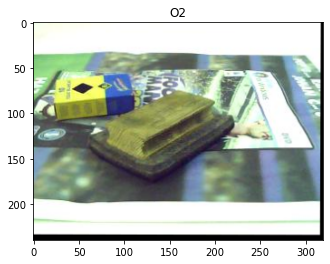

In [31]:
%matplotlib inline
plt.figure()
plt.imshow(cv2.cvtColor(O1, cv2.COLOR_BGR2RGB))
plt.title("O1")
plt.figure()
plt.imshow(cv2.cvtColor(O2, cv2.COLOR_BGR2RGB))
plt.title("O2")

**Ejercicio 11.** Calcula y muestra la matriz fundamental de las imágenes
rectificadas. Justifica el resultado obtenido (mira la sección 9.3.1 del libro de Hartley y Zisserman, pág. 248 y 249).

In [32]:
Fr= projmat2f(
    K @ np.hstack([r_vect, -r_vect @ C_1]),
    K @ np.hstack([r_vect, -r_vect @ C_2])
)

Fr=Fr/Fr[2,1]
print("Fr=\n", Fr)

Fr=
 [[-6.71266885e-23  1.40030965e-18  2.48188027e-15]
 [-1.40035467e-18 -2.55419486e-19 -1.00000000e+00]
 [-2.47999061e-15  1.00000000e+00  2.94695554e-14]]


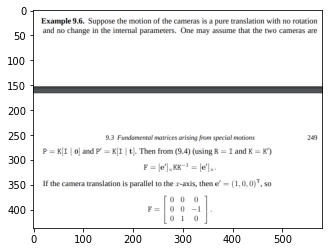

In [33]:
plt.imshow(cv2.cvtColor(cv2.imread("9.6.png"), cv2.COLOR_BGR2RGB))

##### El resultado que encontramos es bueno, se puede comprobar con la explicación de Hartley y Zisserman.
La matriz que obtenemos es igual a
Fr=
 
 [[0  0 0]
 
 [0 0 -1]
 
 [0 1 0]]

**Ejercicio 12.** Usa ``plot_epipolar_lines`` para dibujar varias líneas epiplares de las imágenes rectificadas. Muestra los resultados.

In [34]:
%matplotlib tk
plot_epipolar_lines(O1, O2, Fr)

# VER Imagen n°3

## 4. Búsqueda de correspondencias

La búsqueda de correspondencias consigue establecer automáticamente las correspondencias de puntos entre dos
imágenes (lo que se ha hecho manualmente en el ejercicio 2)
haciendo uso de las restricciones que proporciona la geometría epipolar.

### 4.1 Cálculo de las medidas de semejanza

Una vez rectificadas las dos imágenes de un par estéreo,
se pueden buscar las correspondencias. Una matriz de disparidades $\mathbf{S}$ indica, para cada píxel de la imagen 1
rectificada, a cuántos píxeles de diferencia está su correspondencia
en la imagen 2 rectificada. En la práctica, para simplificar el problema, podemos considerar que los elementos
de $\mathbf{S}$ son enteros. Para el píxel en la posición $(x, y)$ en la imagen 1, su correspondiente está en $(x + S[y, x], y)$ en la
imagen 2. Si $S[y, x] < 0$, la correspondencia está hacia la
izquierda; si $S[y, x] > 0$, la correspondencia está hacia la
derecha; si $S[y, x] = 0$, las coordenadas de los dos puntos
coinciden en ambas imágenes.

La búsqueda de correspondencias requiere ser capaz de
determinar el parecido visual entre píxeles de dos imágenes.
Si los píxeles $m_1$ y $m_2$ son visualmente parecidos, tienen
más probabilidad de estar en correspondencia que otros
que sean visualmente diferentes. Como la
apariencia (el nivel de gris) de un único píxel es propensa
al ruido y poco discriminativa, el elemento de puesta en
correspondencia será una ventana centrada en el píxel.
Dado un píxel $m$ de una imagen, llamaremos vecindad
del píxel de radio $K$ al conjunto de píxeles de la imagen que se encuentren dentro de una ventana de tamaño
$(2K + 1) × (2K + 1)$ píxeles centrada en $m$ . El número de
píxeles de una vecindad de radio $K$ es $N = (2K + 1)^2$.
Dadas dos vecindades $w_1$ y $w_2$ de dos píxeles, el parecido
visual entre ellas puede calcularse con la suma de *diferencias
al cuadrado (SSD)* de cada una de sus componentes
$$d_{SSD}(\mathbf{v}, \mathbf{w}) = \sum_{i=1}^N(\mathbf{v}_i - \mathbf{w}_i)^2.$$

La distancia $d_{SSD}$ es siempre positiva, es pequeña cuando
dos ventanas son visualmente parecidas y grande en caso
contrario.

### 4.2 Estimación de la disparidad sin regularizar

La implementación de cálculo de la disparidad para cada píxel pasa por obtener una matriz D con las distancias entre regiones a lo largo de la línea epipolar. El valor en D será un array de tamaño $M × N × L$, donde L es el número de disparidades a explorar,
``L = len(disps)``; M y N son, respectivamente, el
número de filas y de columnas de las imágenes de entrada.
El elemento ``D[y,x,l]`` debe ser la distancia entre la ventana centrada en ``im1[y,x]`` y la ventana centrada en ``im2[y,x + disps[l]]``.

``D[y,x,l]`` debe ser muy grande para aquellos valores en los que ``im2[y,x + disps[l]]`` no esté definido, es decir, el índice``(y,x+disps[l])`` se sale de la imagen 2.

La matriz D proporciona los costes unitarios $D_i$ de una función de energía sin regularización de la forma $$E(x) = \sum_{i} D_i(x_i),$$
donde $D_i(l)$ viene dado por $D[y,x,l]$, suponiendo que
el píxel $i$ tenga coordenadas $(x, y)$. Las variables 
$x = (x_1 ,\ldots, x_{NM})$ indican las etiquetas de cada uno de los
píxeles. En este caso, las etiquetas son los índices del
array ``disps``, que a su vez son las disparidades horizontales.
Por eso, a partir de aquí se hablará indistintamente de
etiquetas y disparidades. Sólo es necesario recordar que la
etiqueta $l$ está asociada a la disparidad ``disps[l]``.


Minimizando la energía $x = \arg\min_x E(x)$,
se obtiene un vector de etiquetas óptimo $x^*$ que indica, para
cada píxel, cuál es su disparidad horizontal entre las dos
imágenes.

### 4.3 Estimación de la disparidad regulariazada: StereoSGBM

Una vez rectificadas las dos imágenes de un par estéreo, 
y dadas las medidas de semejanza entre píxeles a lo largo 
de la línea epipolar para un rango de disparidades dado, se puede 
modificar la función de energía $E(x)$ para añadir términos de regularización. La idea es que píxeles cercanos tengan una disparidad parecida e intentar evitar los problemas de las zonas de la imagen sin textura.

En OpenCV tenemos implementado el algoritmo presentado en el siguiente artículo:

``Heiko Hirschmuller. Stereo processing by semiglobal matching and mutual information. IEEE Transactions on Pattern Analysis and Machine Intelligence, 30(2):328–341, 2008.``

Aunque la función de coste basada en Información Mútua del paper anterior se ha sustituido por la de Birchfield-Tomasi:

``Stan Birchfield and Carlo Tomasi. A pixel dissimilarity measure that is insensitive to image sampling. IEEE Transactions on Pattern Analysis and Machine Intelligence, 20(4):401–406, 1998.``


La clase que lo implementa el algoritmo de cálculo de disparidades es ``StereoSGBM``. Normalmente en un par estéreo se pretende reconstruir objetos que se encuentran más cerca, y a una distancia dada de la cámara. Esto nos dará lugar a una disparidad mínima a partir de la cual esos píxeles nos interesan (están más lejos que una distancia detertminada a la cámara). El parámetro ``minDisparity`` del algoritmo es crucial para lograr una estimación de disparidad adecuada. También es imporante el parámetro ``numDisparities`` para obtener una mayor o menor glanuralidad en las disparidades.